# Brainwave Service Upload
This Notebook is intended to simplify the training / upload process by splitting the two steps into two separate notebooks. In particular, this Notebook is for uploading a previously-trained model to the cloud, and doesn't contain any training code. It does have some sanity check code to ensure you're loading in the right model, before actually uploading it.

Even though these first few cells are repeated in the training Notebooks, it is necessary here since we still must set up the environment to load the model into memory.

In [1]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2678279902009604215, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15578061210
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5302330717599581887
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [2]:
# These directories were chosen because they write the data to local disk, which will have the fastest access time
# of our various storage options.
custom_weights_dir = os.path.expanduser("../weights-floatingpoint")
custom_weights_dir_q = os.path.expanduser("../weights-quantized")
custom_weights_dir_tl = os.path.expanduser("../weights-transferlearning-floatingpoint")
saved_model_dir = os.path.expanduser("../models")
results_dir = os.path.expanduser("../results")

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form. You will need to edit the paths as necessary.

In [3]:
from utils import normalize_and_rgb, image_with_label, count_events

In [4]:
import glob
datadir = "../data/"
n_train_file = 25
n_test_file = 9
n_val_file = 9

train_files = glob.glob(os.path.join(datadir, 'train_file_*'))
test_files = glob.glob(os.path.join(datadir, 'test/test_file_*'))
val_files = glob.glob(os.path.join(datadir, 'val_file_*'))
train_files = train_files[:n_train_file]
test_files = test_files[:n_test_file]
val_files = test_files[:n_val_file]

n_train_events = count_events(train_files)
n_test_events = count_events(test_files)
n_val_events = count_events(val_files)

print("n_train_events =", n_train_events)
print("n_test_events =", n_test_events)
print("n_val_events =", n_val_events)

n_train_events = 1211000
n_test_events = 404000
n_val_events = 404000


## Construct Model
We use ResNet50 for the featuirzer and build our own classifier using Keras layers. We train the featurizer and the classifier as one model. The weights trained on ImageNet are used as the starting point for the retraining of our featurizer. The weights are loaded from tensorflow checkpoint files.

Before passing image dataset to the ResNet50 featurizer, we need to preprocess the input file to get it into the form expected by ResNet50. ResNet50 expects float tensors representing the images in BGR, channel last order. Given that our images are greyscale, this isn't relevant to us, as we will simply be copying the data in place.

In [5]:
from utils import preprocess_images

We use Keras layer APIs to construct the classifier. Because we're using the tensorflow backend, we can train this classifier in one session with our Resnet50 model.

In [6]:
from utils import construct_classifier

Now every component of the model is defined, we can construct the model. Constructing the model with the project brainwave models is two steps - first we import the graph definition, then we restore the weights of the model into a tensorflow session. Because the quantized graph defintion and the float32 graph defintion share the same node names in the graph definitions, we can initally train the weights in float32, and then reload them with the quantized operations (which take longer) to fine-tune the model.

In [7]:
from utils import construct_model

## Load And Check The Model
If you already have a trained up, quantized model and don't want to train it any further before uploading it to the Azure server, run this cell. It will load the model and its weights into ram without applying any gradient descents. It will then perform a quick sanity check to ensure the loaded model is the one expected by passing the test images through it.

In [8]:
from utils import chunks, test_model

tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Testing trained model with quantization")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, saved_model_dir=saved_model_dir, starting_weights_directory=custom_weights_dir_q, is_training=False)
    loss, accuracy, auc, preds_test, test_labels = test_model(preds, in_images, test_files[:1])
    print("Accuracy:", accuracy, ", Area under ROC curve:", auc)

Testing trained model with quantization
in restore_weights
checkpoint directory: ../weights-quantized
lastest checkpoint: ../weights-quantized/resnet50_bw_best
INFO:tensorflow:Restoring parameters from ../weights-quantized/resnet50_bw_best
loading classifier weights from ../weights-quantized/class_weights.h5


100%|██████████| 782/782 [04:40<00:00,  3.25it/s]


test_loss =  0.487
Test Accuracy: 0.685 , Area under ROC curve: 0.816
Accuracy: 0.6853200000000016 , Area under ROC curve: 0.8164971537971497


## Just Load The Model
If you already have a trained up, quantized model and don't want to train it any further before uploading it to the Azure server, run this cell. It will load the model and its weights into ram without applying any gradient descents. 

In [21]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading quantized model")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, saved_model_dir=saved_model_dir, starting_weights_directory=custom_weights_dir_q)

Loading quantized model
in restore_weights
checkpoint directory: ../weights-floatingpoint
lastest checkpoint: ../weights-floatingpoint/resnet50_bw
INFO:tensorflow:Restoring parameters from ../weights-floatingpoint/resnet50_bw
loading classifier weights from ../weights-floatingpoint/class_weights.h5


## Service Definition
Like in the QuickStart notebook our service definition pipeline consists of three stages.

In [9]:
from azureml.contrib.brainwave.pipeline import ModelDefinition, TensorflowStage, BrainWaveStage

model_def_path = os.path.join(saved_model_dir, 'model_def.zip')

model_def = ModelDefinition()
model_def.pipeline.append(TensorflowStage(sess, in_images, image_tensors))
model_def.pipeline.append(BrainWaveStage(sess, quantized_featurizer))
model_def.pipeline.append(TensorflowStage(sess, features, preds))
model_def.save(model_def_path)
print(model_def_path)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
in restore_weights
checkpoint directory: ../weights-quantized
lastest checkpoint: ../weights-quantized/resnet50_bw_best
INFO:tensorflow:Restoring parameters from ../weights-quantized/resnet50_bw_best
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
../models/model_def.zip


## Deploy
Go to our GitHub repo "docs" folder to learn how to create a Model Management Account and find the required information below.

In [10]:
from azureml.core import Workspace

ws = Workspace.from_config()

Found the config file in: /home/dwerran/machinelearningnotebooks/aml_config/config.json


The first time the code below runs it will create a new service running your model. If you want to change the model you can make changes above in this notebook and save a new service definition. Then this code will update the running service in place to run the new model.

In [11]:
from azureml.core.model import Model
from azureml.core.image import Image
from azureml.core.webservice import Webservice
from azureml.contrib.brainwave import BrainwaveWebservice, BrainwaveImage
from azureml.exceptions import WebserviceException

model_name = "top-transfer-resnet50-model"
image_name = "top-transfer-resnet50-image"
service_name = "modelbuild-service"

registered_model = Model.register(ws, model_def_path, model_name)

image_config = BrainwaveImage.image_configuration()
deployment_config = BrainwaveWebservice.deploy_configuration()
    
try:
    service = Webservice(ws, service_name)
    service.delete()
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)
except WebserviceException:
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)

Registering model top-transfer-resnet50-model
Creating image
Image creation operation finished for image modelbuild-service:20, operation "Succeeded"
Creating service
Running.....................................................
SucceededFPGA service creation operation finished, operation "Succeeded"


The service is now running in Azure and ready to serve requests. We can check the address and port.

In [12]:
print(service.ip_address + ':' + str(service.port))

52.168.151.218:80


## Client
There is a simple test client at amlrealtimeai.PredictionClient which can be used for testing. We'll use this client to score an image with our new service.

In [13]:
from azureml.contrib.brainwave.client import PredictionClient
client = PredictionClient(service.ip_address, service.port)

## Request
Let's see how our service does on a few images. It may get a few wrong.

In [14]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from utils import chunks

test_files = test_files[:1]  # For now...

chunk_size = 1  # Brainwave only processes one request at a time
n_test_events = count_events(test_files)
chunk_num = int(n_test_events/chunk_size)+1

correct = 0
y_true = np.array([])
y_pred = np.array([])

for img_chunk, label_chunk, real_chunk_size in tqdm(chunks(test_files, chunk_size), total=chunk_num):
    results = client.score_numpy_array(img_chunk)
    if (results[0][0] > results[0][1]) == label_chunk[0][0]:
        correct += 1
        
    y_true = np.append(y_true, label_chunk[0][0])  # Convert from one-hot to true/false
    y_pred = np.append(y_pred, results[0][0])

accuracy = correct / n_test_events
auc = roc_auc_score(y_true, y_pred)

# Call the save results utility.
save_results(results_dir, 'b', accuracy, y_true, y_pred)

print("Accuracy:", accuracy, "AUC:", auc)

Accuracy: 0.9008 AUC: 0.9795795474910393


## Plot results
If results exist for floating point training, quantization, fine tuning, and Brainwave, this should run without issues. If you have fewer, go to utils.py and comment out the irrelevant lines.

Brainwave: 0.9008 0.9795795474910393 0.2976984126984127 652.6315789473684


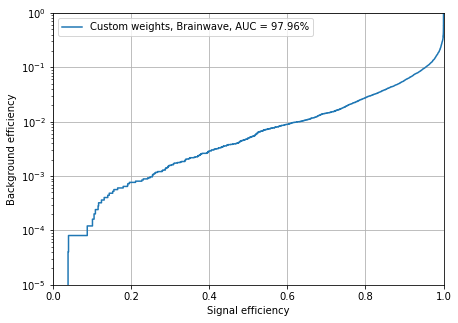

In [21]:
plot_results(results_dir)

## Cleanup
Run the cell below to delete your service.

In [22]:
service.delete()